<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Pre-Implementation** 

After running all the baseline methods on all our data, we find the classification technique with the highest test accuracy for the best dev model is odinal regression- accuracy of 0.440 verus 0.430 (BERT), 0.440 (Majority Class) and 0.420 (Logistic Regression).


Even though ordinal regression has the highest base accuracy, we decided to go with a BERT model as we found adding features to BERT produced found higher end accuracys.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
!pip3 install transformers
!pip3 install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 675.5 kB/s eta 0:00:00


In [3]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data"

Use our newly created cleaning functions in read_data

In [5]:
adjudicated = pd.read_csv(f'/content/drive/MyDrive/ap_data/adjudicated.txt', sep = '\t', header = None)
adjudicated = adjudicated.iloc[:,2:]
adjudicated.rename(columns={2:'Informativeness',3:'Review_Text'},inplace=True)
adjudicated

,Informativeness,Review_Text
0,3,"If you decide to eat here, just be aware it is..."
1,4,Family diner. Had the buffet. Eclectic assortm...
2,3,This easter instead of going to Lopez Lake we ...
3,3,Had a party of 6 here for hibachi. Our waitres...
4,3,"Upland is a brewery based out of Bloomington, ..."
...,...,...
495,3,We have been on many cruises on other lines bu...
496,3,"If you want anything fresh, you gotta come her..."
497,2,So I walked up to the Cajun Grill while trying...
498,4,"Been here a few times over the years, mainly w..."


In [6]:
train = adjudicated.iloc[:300,:]
train.head()

,Informativeness,Review_Text
0,3,"If you decide to eat here, just be aware it is..."
1,4,Family diner. Had the buffet. Eclectic assortm...
2,3,This easter instead of going to Lopez Lake we ...
3,3,Had a party of 6 here for hibachi. Our waitres...
4,3,"Upland is a brewery based out of Bloomington, ..."


In [7]:
develop = adjudicated.iloc[300:400,:]
develop.head()

,Informativeness,Review_Text
300,3,This is a great place to visit if you enjoy la...
301,3,Hickory Hollow really isn't that bad. If you d...
302,3,Chris was our server and he was great. He seem...
303,3,I really hate having to give Lucky Belly a 3 s...
304,4,We went on a friday evening around 5:30 and we...


In [8]:
test = adjudicated.iloc[400:500,:]
test.head()

,Informativeness,Review_Text
400,1,Excellent food. Nice location. Only complaint ...
401,1,"But, It might be a 2 stars. All of the staff ..."
402,3,Fast food style Greek food. I would bet most ...
403,2,Came in here on a Friday night not really expe...
404,1,The Indian cinnamon donuts are delicious! The...


We visualize the training data by drawing a bar chart showing the number of reviews correspond to each Informativeness level. As shown in the graph below, among all reviews in training data, the majorities were labeled as 2.

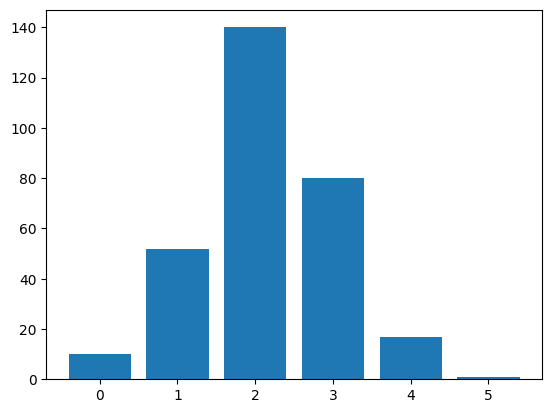

In [9]:
plt.bar(x=train["Informativeness"].value_counts().index, height=train["Informativeness"].value_counts().values)
plt.show()

We also compute the average review length for each level of Informativeness and as shown in the table below, longer reviews tend to receive higher ratings. This pattern suggest that review length might be considered as a feature when building our model.

In [76]:
train['Review_Length'] = train["Review_Text"].apply(lambda x: len(str(x).split(' ')))
train_text_length_avg = train.groupby('Informativeness').mean().reset_index().rename(columns={'Review_Length':'Average_Review_Length'})
train_text_length_avg

<ipython-input-76-e56758ef5b24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Review_Length'] = train["Review_Text"].apply(lambda x: len(str(x).split(' ')))
<ipython-input-76-e56758ef5b24>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_text_length_avg = train.groupby('Informativeness').mean().reset_index().rename(columns={'Review_Length':'Average_Review_Length'})


,Informativeness,Average_Review_Length
0,0,48.600000
1,1,57.807692
2,2,102.907143
3,3,147.175000
4,4,194.529412
5,5,306.000000


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import string
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = text.strip()
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return ' '.join(text)

In [13]:
train['clean_text'] = train['Review_Text'].apply(lambda x : clean_text(x))
develop['clean_text'] = develop['Review_Text'].apply(lambda x : clean_text(x))
test['clean_text'] = test['Review_Text'].apply(lambda x : clean_text(x))

<ipython-input-13-dc6bdb354a63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['clean_text'] = train['Review_Text'].apply(lambda x : clean_text(x))
<ipython-input-13-dc6bdb354a63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  develop['clean_text'] = develop['Review_Text'].apply(lambda x : clean_text(x))
<ipython-input-13-dc6bdb354a63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [14]:
train.head()

,Informativeness,Review_Text,Review_Length,clean_text
0,3,"If you decide to eat here, just be aware it is...",103,If decide eat aware going take hour beginning ...
1,4,Family diner. Had the buffet. Eclectic assortm...,55,Family diner Had buffet Eclectic assortment la...
2,3,This easter instead of going to Lopez Lake we ...,102,This easter instead going Lopez Lake went Los ...
3,3,Had a party of 6 here for hibachi. Our waitres...,99,Had party hibachi Our waitress brought separat...
4,3,"Upland is a brewery based out of Bloomington, ...",140,Upland brewery based Bloomington Indiana becom...


First using  Logistic Regression with TF-IDF for classifications. Based on the train set the accuracy is 0.55

In [15]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from sklearn.model_selection import train_test_split

In [16]:
vectorizer = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(train['clean_text'], train['Informativeness'], test_size=0.2, random_state=42)
# Fit the vectorizer on the training data and transform it
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = vectorizer.transform(X_test)

# Create a Logistic Regression model
logreg = LogisticRegression()

# Train the model on the training data
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         5
           2       0.56      0.94      0.70        34
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00         7

    accuracy                           0.55        60
   macro avg       0.18      0.21      0.17        60
weighted avg       0.38      0.55      0.42        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Training the Model**

In [17]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math

In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


First step to bettering the base model is cleaning our input data.  This includes removing puncuation, removing stop words, and performing lemmantization.

Here, we use our clean_text method to do such

In [19]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            text = cols[3]
            text = clean_text(text)

            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [20]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            if label not in labels:
                labels[label]=len(labels)
    return labels

Now, we continue with training the model as provided in the AP4 guidelines

In [21]:
labels=read_labels("%s/train.txt" % directory)

In [22]:
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)

In [23]:
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels, max_data_points=None)

In [24]:
test_x, test_y=read_data("%s/test.txt" % directory, labels, max_data_points=None)

In [25]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total

In [26]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

Note: Use cpu instead of cuda because of memory issues with cuda.

In [27]:
device = torch.device("cpu")
print("Running on {}".format(device))

Running on cpu


In [28]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [29]:
def train_model(classifier, bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = classifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model



In [ ]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="google/bert_uncased_L-2_H-128_A-2"
model_filename="mybert.model"
embedding_size=128
doLowerCase=True

bert_model=train_model(BERTClassifier, bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.420
Epoch 1, dev accuracy: 0.430
Epoch 2, dev accuracy: 0.450
Epoch 3, dev accuracy: 0.450
Epoch 4, dev accuracy: 0.450
Epoch 5, dev accuracy: 0.450
Epoch 6, dev accuracy: 0.440
Epoch 7, dev accuracy: 0.430
Epoch 8, dev accuracy: 0.440
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.450


In [ ]:
test_batch_x, test_batch_y = bert_model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(bert_model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.480, 95% CIs: [0.382 0.578]



Above, we created a BERT classifier with 0.480 accuracy.  We were able to get this improved accuracy (baseline 0.460) by just adding one additional feature: data prepreocessing.  To be fair, this preprocessing was relatively extensive and involved removing puncuation, tokenization, removing stopwords, and lemmatization; thus, the improved accuracy is expected. 

However, we can do better than this.  There are many ways to improve a BERT classifier.  One of these ways is in reference to its architecture.  This can be done by fine tuning layers, playing with predefined models, etc..

What we tackle below is in this realm.  We modify the baseline method above to fit with a DistilBERTTokenizer.  Then, we combine the models for our final.  

The implementation is below





## **DistilBERT**

Note: the above train_model function was edited to include a 'Classifier' parameter as to work with the newly implemented DistilBertClassifer below and the reference BertClassifier above.

In [29]:
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import pipeline
import torch
import torch.nn as nn

The DistilBertClassifier is very similar to the BERT classifier above, however, it uses its own tokenizer, model call, and paramters for self.fc.

Note: we use the BertTokenizer to run quickier

Reference: https://towardsdatascience.com/everything-you-need-to-know-about-albert-roberta-and-distilbert-11a74334b2da

In [ ]:
class DistilBertClassifier(nn.Module):

    def __init__(self, distil_model_name, params):
        super().__init__()
    
        self.model_name=distil_model_name
        self.tokenizer = DistilBertTokenizer.from_pretrained(self.model_name)
        self.db = DistilBertModel.from_pretrained(self.model_name)

        self.embedding_size=params["embedding_size"]
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(self.db.config.hidden_size, self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+32]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+32]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        db_output = self.db(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = db_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

Note, we have to train the model

In [ ]:
model_name="distilbert-base-uncased"
model2_filename="mydb.model"
embedding_size=128
doLowerCase=True

db_model=train_model(DistilBertClassifier, model_name, model2_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.440
Epoch 1, dev accuracy: 0.440
Epoch 2, dev accuracy: 0.550
Epoch 3, dev accuracy: 0.530
Epoch 4, dev accuracy: 0.520
Epoch 5, dev accuracy: 0.510
Epoch 6, dev accuracy: 0.480
Epoch 7, dev accuracy: 0.490
Epoch 8, dev accuracy: 0.450
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.550


In [ ]:
test_batch_x, test_batch_y = db_model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(db_model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.530, 95% CIs: [0.432 0.628]



After training the new model, we see a  better accuracy score of 0.530.  We have improved from our original model that included data processing, but we will progress by adding another feature.  This feature will be a combination of the two models. 

This implementation is below.  



### **Combined Final Model**

First, we need to create a classifier for the two models.

Again, we will heavily reference the provided cclassifier code, but will make many changes. 

In [30]:
class CombinedClassifier(nn.Module):

    def __init__(self, bert_model_name, distil_model_name, params):
        super().__init__()
    
        self.db_model_name=distil_model_name
        self.bert_model_name=bert_model_name
        self.dropout = nn.Dropout(0.1)

        self.tokenizer = DistilBertTokenizer.from_pretrained(self.db_model_name)

        self.db =  DistilBertModel.from_pretrained(self.db_model_name)
        self.bert = BertModel.from_pretrained(self.bert_model_name)

        self.embedding_size=params["embedding_size"]
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(self.db.config.hidden_size+self.embedding_size, self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+32]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+32]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        db_output = self.db(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         output_hidden_states=True)
        db_hidden_state = db_output.last_hidden_state[:, 0, :]


        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         output_hidden_states=True)
        bert_hidden_state = bert_output.last_hidden_state[:, 0, :]

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        combined_hidden_states = torch.cat((db_hidden_state, bert_hidden_state), dim=1)
        out = self.dropout(combined_hidden_states)

        out = self.fc(out)

        return out.squeeze()

Now, we have to rework our train_model function to handle two models.

This is a small change and involves adding an extra parameter to the function

In [31]:
def train_model2(classifier, bert_model_name, db_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    combined_model = classifier(bert_model_name, db_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    combined_model.to(device)

    batch_x, batch_y = combined_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = combined_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(combined_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        combined_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = combined_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, combined_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(combined_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(combined_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    combined_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return combined_model


Now, we train the final model.

In [32]:
bert_model_name="google/bert_uncased_L-2_H-128_A-2"
db_model_name="distilbert-base-uncased"
model_filename="combined_model"
embedding_size=128
doLowerCase=True

combined_model=train_model2(CombinedClassifier, bert_model_name, db_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.440
Epoch 1, dev accuracy: 0.440
Epoch 2, dev accuracy: 0.470
Epoch 3, dev accuracy: 0.460
Epoch 4, dev accuracy: 0.520
Epoch 5, dev accuracy: 0.520
Epoch 6, dev accuracy: 0.570
Epoch 7, dev accuracy: 0.540
Epoch 8, dev accuracy: 0.550
Epoch 9, dev accuracy: 0.510
Epoch 10, dev accuracy: 0.480
Epoch 11, dev accuracy: 0.480
Epoch 12, dev accuracy: 0.480
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.570


In [33]:
test_batch_x, test_batch_y = combined_model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(combined_model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.640, 95% CIs: [0.546 0.734]



In all, our final model has a test accuracy of 0.640 with 95% CIs of 0.546, 0.734

**Part B Analysis:**

To understand our labels and to create a confusion matrix, we need to access our model's predicted y values for the test data we have set aside

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math

In [67]:
def find_predicted_values(model, x, y):
    model.eval()
    prediction = [...]
    actual_values = [...]
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                actual_values.append((y[idx]).item())
                prediction.append(torch.argmax(y_pred).item())                        
    return prediction, actual_values

In [68]:
pred_values, actual_values = find_predicted_values(combined_model, test_batch_x, test_batch_y)
del pred_values[0]
del actual_values[0]

**Charts**

ValueError: ignored

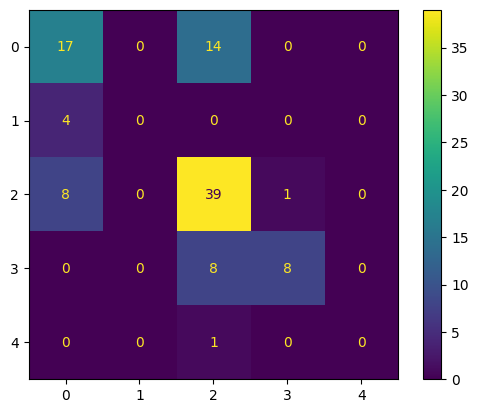

In [70]:
cf_matrix = confusion_matrix(actual_values, pred_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=np.array([0,1,2,3,4,5]))
disp.plot()

From above, we can see that our model is extremely congregated around the labels of 2 and 3.  
In some ways, this is good.  If you look at our actual labels, this tends to be true- meaning, most of the actual labels are 2 or 3.  However, our model completely mislabels any of the higher ranking reviews.  
Even though high ranking reviews are rare- it would be benefical if our model could predict these as well.  However, it does a good job on most of the data.

In [71]:
data = {'Model':['Logistic Regression with TF-IDF ','Bert with data cleaning','DistilBERT', 'Final Combined Model'],
        'Accuracy':[0.55,0.48,0.53,0.70]}
data_df = pd.DataFrame(data=data)
data_df

,Model,Accuracy
0,Logistic Regression with TF-IDF,0.55
1,Bert with data cleaning,0.48
2,DistilBERT,0.53
3,Final Combined Model,0.64


In [72]:
train_count = train.groupby(adjudicated["Informativeness"]).count()
train_count

,Informativeness,Review_Text,Review_Length,clean_text
Informativeness,,,,
0,10,10,10,10
1,52,52,52,52
2,140,140,140,140
3,80,80,80,80
4,17,17,17,17
5,1,1,1,1


In [73]:
train_long_text = train.loc[train["Review_Length"] > 256]
train_long_text.groupby(train_long_text["Informativeness"]).count()

,Review_Text,Review_Length,clean_text
Informativeness,,,
1,1,1,1
2,6,6,6
3,9,9,9
4,3,3,3
5,1,1,1


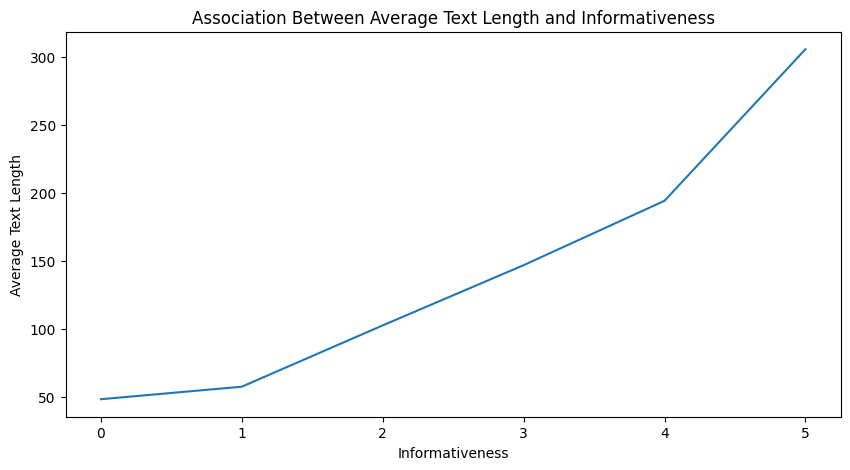

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x='Informativeness', y='Average_Review_Length', data=train_text_length_avg)
plt.title('Association Between Average Text Length and Informativeness')
plt.xlabel('Informativeness')
plt.ylabel('Average Text Length')
plt.show()


**In Depth Analysis**

The reason why the Bert model doesn't perform well on high labels such as (4,5) could be due to several reasons. First of all, based on the graph, we only have one sample of label 5 and 10 samples of 0. Due to the extremely small amount of the sample, it is really hard to increase the accuracy based on the small sample size. Another potential reason is the choice of a maximum token size of 256, which was constrained by our GPU resources. From the data cleaning part, we know higher informativeness is positively associates with the length of the text. This smaller token size may have prevented the model from learning the complete sequence of many reviews potentially increasing the probability that higher informativeness will have a higher chance of being misclassified. As a result, due to the nature of the train set, we couldn’t increase the accuracy score higher.

Moreover, we identified a design flaw in our annotation guidelines for measuring "informativeness." We divided informativeness into five categories, with a review earning one point for each category it addresses. However, if a review discusses one category multiple times, it doesn't receive more than one point. This limitation means that the model has increased opportunities to learn features of that particular category, which caused an imbalance issue.

Our model does present some biases towards review that includes more adjectives. As we have looked closer into the granularity of our dataset and prediction, reviews that heavily contain adjectives have taken greater weight in being classified as good reviews (3 - 5)
However, not all of these adjectives are useful in some sense in helping to increase the informativeness of the review. Even with certain redundancy that hinders revealing the nature of the business that it is describing. This should suggest an improvement in how we define the quality of a post as it should be closer to more humanly explainable language instead fancy usage of words that vague the true feelings and judgment of the business one is describing.


By reading through test predictions and manually categorizing mistakes that are made, we have found that our model systemically made the mistake of misclassifying reviews with the informativeness of 1 and 5. By looking closely at the ones that were falsely classified, we have discovered that even with reviews that aren't very specific, as long as they contain some kind of sentiments on how the business or services can be improved upon can be classified as 5. This indicates that our model may not have captured the full capacity of what constitutes a score 5 review as it requires more than just suggestions on improvements or sentiments on the perspective of what is bad or good. Instead, this should be set as an add-on requirement for quality control on the models that are based on further previous requirements specified for the previous scores. Another systemic mistake that we have discovered lies in the fact that our model doesn't really take into account sarcastic reviews that may have meant positive sentiments but are classified as negative. Although only very few datasets have shown this error, it also shows the limitation of what our language presents in classifying more couple human language structure and representation.